In [4]:
using CairoMakie
using Random
using Distributions
using LinearAlgebra

In [66]:
function nearest_neighbor_distance(y, data, k)
    distance = dist2(y, data)
    return sqrt.(sort(distance)[k])
end

function dist2(x, y)
    return sum(abs2.(μ .- data); dims=1)[:]
end

function nearest_neighbor_kernel(x)
    return dist2(x, 0) .>= 1
end

function kde_knn_estimate(y, data, k, d, N)
    knn_distance = nearest_neighbor_distance(y, data, k)
    weighted_sample = (data .- y) / knn_distance
    return 1/(N * knn_distance^d) * sum(nearest_neighbor_kernel(weighted_sample))
end

kde_knn_estimate (generic function with 1 method)

In [72]:
Random.seed!(123)
N = 350
d = 2
μ = zeros(d)
Σ = I(d)
dist = MvNormal(μ, Σ)
data = rand(dist, N)

true_pdf(x) = (2*pi)^(-d/2)*det(Σ)^(-1/2)*exp.(-1/2*(x .- μ)'\Σ*(x .- μ))
nearest_neighbor_distance(μ, data, 1)

k = 3
println(kde_knn_estimate(μ, data, k, d, N))
println(true_pdf(μ))

39.57578735686898


LoadError: DimensionMismatch: arguments must have the same number of rows

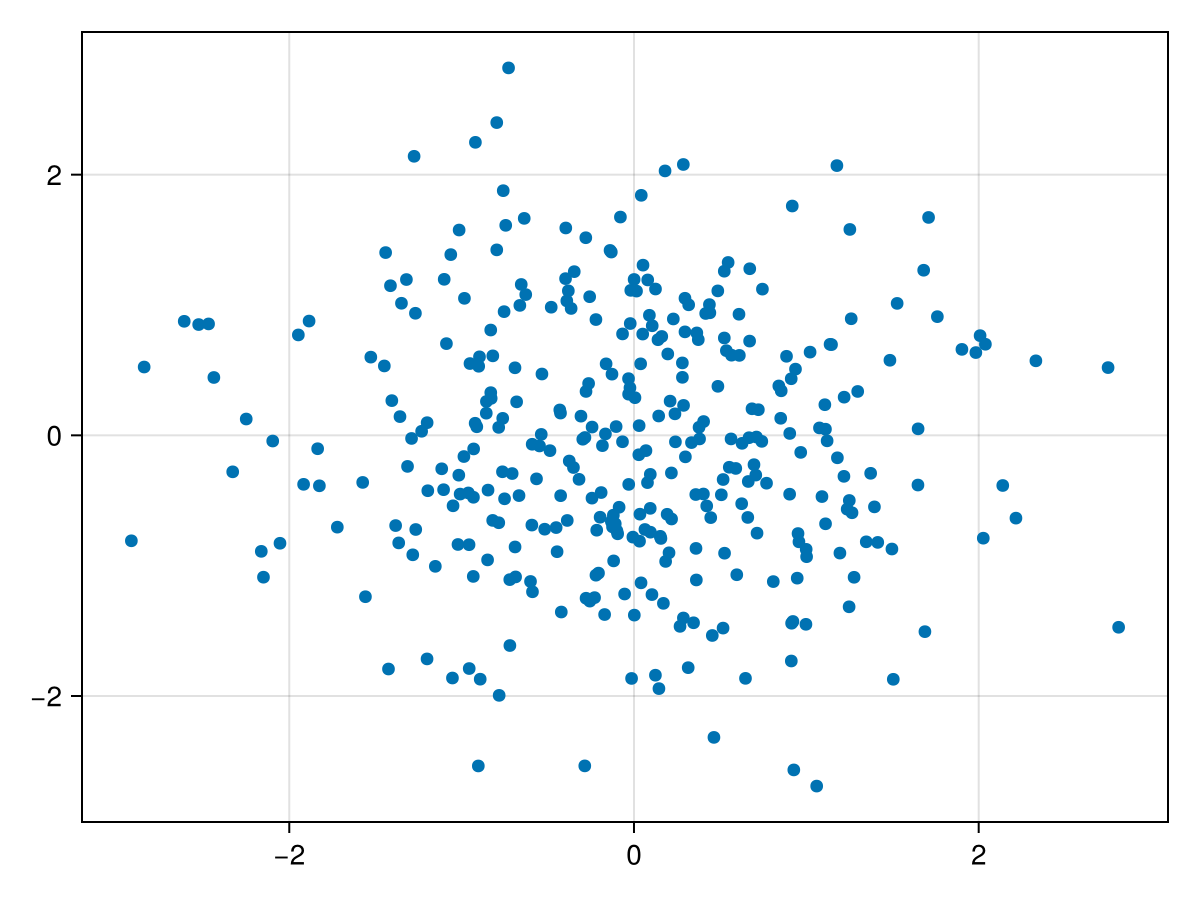

In [51]:
f = Figure()
ax = Axis(f[1,1])

scatter(data[1, :], data[2, :])

In [75]:
-1/2*(μ .- μ)'\Σ*(μ .- μ)

2-element Vector{Float64}:
 0.0
 0.0